In [18]:
from pathlib import Path
from importlib import reload

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit

import processing

reload(processing)
from processing import load_data

## Loading Data

In [2]:
DATA_DIR = Path('../data/results').resolve()
assert DATA_DIR.is_dir()

OUTPUT_DIR = Path('./output').resolve()
OUTPUT_DIR.mkdir(exist_ok=True)

In [3]:
nearestx_times_path = DATA_DIR / "times_nearest_x.csv"
hilbert_times_path = DATA_DIR / "times_hilbert_curve.csv"
str_times_path = DATA_DIR / "times_sort_tile_recursive.csv"

nearestx_reads_path = DATA_DIR / "reads_nearest_x.csv"
hilbert_reads_path = DATA_DIR / "reads_hilbert_curve.csv"
str_reads_path = DATA_DIR / "reads_sort_tile_recursive.csv"

nearestx = {
    'times': load_data(nearestx_times_path),
    'reads': load_data(nearestx_reads_path),
}

hilbert = {
    'times': load_data(hilbert_times_path),
    'reads': load_data(hilbert_reads_path),
}

sort_tile_recursive = {
    'times': load_data(str_times_path),
    'reads': load_data(str_reads_path),
}

In [4]:
nearestx['times'].head()

,2¹⁰,2¹¹,2¹²,2¹³,2¹⁴,2¹⁵,2¹⁶,2¹⁷,2¹⁸,2¹⁹,2²⁰,2²¹,2²²,2²³,2²⁴,2²⁵
q1,565,561,792,769,979,1412,1671,2652,5574,9724,19724,35456,68967,145446,276607,543843
q2,66,291,505,764,1066,765,1407,2440,3656,6951,11895,20060,43077,91208,173796,347186
q3,105,106,320,500,352,991,1597,1897,3688,4979,11545,22257,43014,88140,165625,331749
q4,98,128,232,153,267,809,1059,2775,4775,9180,18497,37416,70516,151291,291216,588251
q5,87,114,166,104,199,362,920,1531,3287,5901,11547,24591,44145,100588,196189,394989


## Results (Tables)

In [5]:
def confidence_interval(data, confidence=0.95) -> tuple[float, float]:
    """
    Calculate a confidence interval for the mean of a sample using the t-distribution.

    Parameters:
        data (array-like): The sample data.
        confidence (float): The desired confidence level (default is 0.95).

    Returns:
        tuple: A tuple containing the lower and upper bounds of the confidence interval.
    """
    # Calculate the sample mean and standard deviation
    sample_mean = np.mean(data)
    sample_std = np.std(data, ddof=1)

    # Calculate the t-value for the desired confidence level with n-1 degrees of freedom
    n = len(data)
    t_value = stats.t.ppf((1 + confidence) / 2, df=n - 1)

    # Calculate the confidence interval
    lower_ci = sample_mean - t_value * sample_std / np.sqrt(n)
    upper_ci = sample_mean + t_value * sample_std / np.sqrt(n)

    # Return the confidence interval as a tuple
    return (lower_ci, upper_ci)


def compute_confidence_intervals(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute the confidence interval for the mean of each column in the given dataframe.

    Parameters:
        df (pandas.DataFrame): The dataframe containing the data.

    Returns:
        pandas.DataFrame: A dataframe containing the confidence intervals for each column.
    """
    return pd.DataFrame(
        [confidence_interval(df[col]) for col in df.columns],
        index=df.columns,
        columns=["lower", "upper"],
    )


def make_table(
    times: pd.DataFrame, reads: pd.DataFrame
) -> pd.DataFrame:
    ci_times = compute_confidence_intervals(times)
    ci_reads = compute_confidence_intervals(reads)
    return pd.DataFrame(
        {
            "n": ci_times.index,
            f"Duration mean [µs]": times.mean().round(2),
            f"Duration CI": ci_times.apply(lambda x: f"[{x['lower']:.2f}, {x['upper']:.2f}]", axis=1),
            f"Reads mean": reads.mean().round(2),
            f"Reads CI": ci_reads.apply(lambda x: f"[{x['lower']:.2f}, {x['upper']:.2f}]", axis=1),
        }
    ).reset_index(drop=True)
    
def generate_latex_table(df: pd.DataFrame) -> None:
    print("\\begin{center}")
    print(df.to_latex(index=False))
    print("\\end{center}")

In [6]:
nearestx = make_table(nearestx['times'], nearestx['reads'])
hilbert = make_table(hilbert['times'], hilbert['reads'])
sort_tile_recursive = make_table(sort_tile_recursive['times'], sort_tile_recursive['reads'])


In [7]:
# generate_latex_table(str_table)

## Plotting Data

In [8]:
nearestx.head()

,n,Duration mean [µs],Duration CI,Reads mean,Reads CI
0,2¹⁰,70.32,"[59.72, 80.92]",3.01,"[2.87, 3.15]"
1,2¹¹,99.61,"[87.91, 111.31]",4.11,"[3.87, 4.35]"
2,2¹²,73.74,"[54.95, 92.53]",6.19,"[5.72, 6.66]"
3,2¹³,115.97,"[93.80, 138.14]",10.42,"[9.48, 11.36]"
4,2¹⁴,195.88,"[165.61, 226.15]",19.89,"[18.03, 21.75]"


### Comparting time

In [24]:
nearestx['Duration mean [µs]']

0         70.32
1         99.61
2         73.74
3        115.97
4        195.88
5        354.14
6        659.24
7       1299.68
8       2542.60
9       4966.17
10      9949.27
11     19778.06
12     38973.23
13     79268.39
14    158073.80
15    322614.74
Name: Duration mean [µs], dtype: float64

In [34]:
nearestx["n"]

0     2¹⁰
1     2¹¹
2     2¹²
3     2¹³
4     2¹⁴
5     2¹⁵
6     2¹⁶
7     2¹⁷
8     2¹⁸
9     2¹⁹
10    2²⁰
11    2²¹
12    2²²
13    2²³
14    2²⁴
15    2²⁵
Name: n, dtype: object

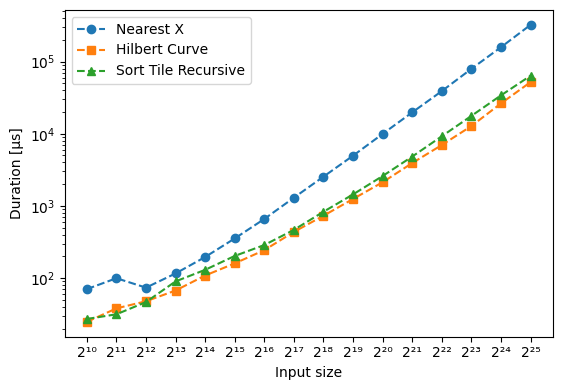

In [36]:
fig, ax = plt.subplots(figsize=(6, 4))
x = range(16)
xticks = nearestx["n"]
plt.xticks(x, xticks)
plt.plot(
    x, nearestx["Duration mean [µs]"], label="Nearest X", linestyle="--", marker="o"
)
plt.plot(
    x, hilbert["Duration mean [µs]"], label="Hilbert Curve", linestyle="--", marker="s"
)
plt.plot(
    x,
    sort_tile_recursive["Duration mean [µs]"],
    label="Sort Tile Recursive",
    linestyle="--",
    marker="^",
)
plt.xlabel("Input size")
plt.ylabel("Duration [µs]")
plt.legend()
plt.tight_layout()
plt.yscale("log")
plt.show()

### Comparing Reads

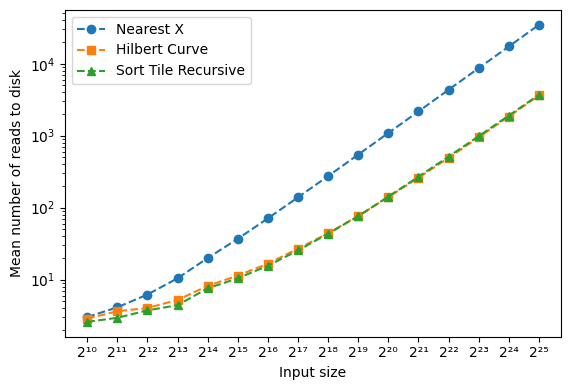

In [37]:
fig, ax = plt.subplots(figsize=(6, 4))
x = range(16)
xticks = nearestx["n"]
plt.xticks(x, xticks)
plt.plot(
    x, nearestx["Reads mean"], label="Nearest X", linestyle="--", marker="o"
)
plt.plot(
    x, hilbert["Reads mean"], label="Hilbert Curve", linestyle="--", marker="s"
)
plt.plot(
    x,
    sort_tile_recursive["Reads mean"],
    label="Sort Tile Recursive",
    linestyle="--",
    marker="^",
)
plt.xlabel("Input size")
plt.ylabel("Mean number of reads to disk")
plt.legend()
plt.tight_layout()
plt.yscale("log")
plt.show()

## Curve fitting

In [45]:
def time_function(n: int, c: float, alpha: float) -> float:
    """f(n) = c * n^alpha"""
    return c * n ** alpha

In [46]:
nearestx['Duration mean [µs]'].values

array([7.0320000e+01, 9.9610000e+01, 7.3740000e+01, 1.1597000e+02,
       1.9588000e+02, 3.5414000e+02, 6.5924000e+02, 1.2996800e+03,
       2.5426000e+03, 4.9661700e+03, 9.9492700e+03, 1.9778060e+04,
       3.8973230e+04, 7.9268390e+04, 1.5807380e+05, 3.2261474e+05])

In [47]:
x = [2**i for i in range(10, 26)]
y_nearestx = nearestx['Duration mean [µs]'].values
y_hilbert = hilbert['Duration mean [µs]'].values
y_str = sort_tile_recursive['Duration mean [µs]'].values

In [48]:
popt_nearestx, pcov_nearestx = curve_fit(time_function, x, y_nearestx)
popt_hilbert, pcov_hilbert = curve_fit(time_function, x, y_hilbert)
popt_str, pcov_str = curve_fit(time_function, x, y_str)

In [49]:
print(f"NearestX: c={popt_nearestx[0]}, alpha={popt_nearestx[1]}")
print(f"Hilbert: c={popt_hilbert[0]}, alpha={popt_hilbert[1]}")
print(f"Sort Tile Recursive: c={popt_str[0]}, alpha={popt_str[1]}")

NearestX: c=0.007141049367720474, alpha=1.0170995577341595
Hilbert: c=0.0022934922842550256, alpha=0.9772074647880911
Sort Tile Recursive: c=0.0075236431716888975, alpha=0.9205870268341265


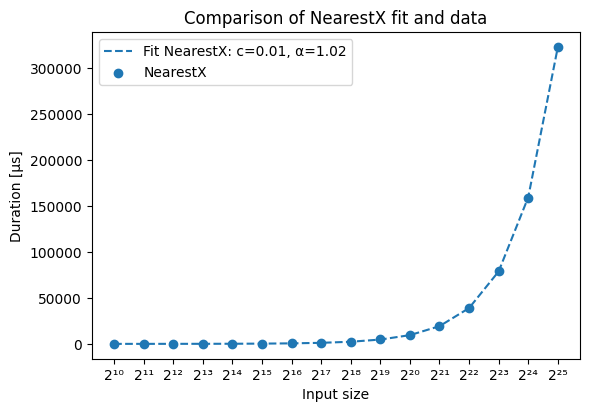

In [57]:
def plot_fit(y, popt, algorithm):
    plt.figure(figsize=(6, 4))
    x = range(16)
    x_ticks = nearestx["n"]
    plt.xticks(x, x_ticks)
    y_fit = [time_function(n, *popt) for n in [2**i for i in range(10, 26)]]
    
    plt.plot(x, y_fit, label=f"Fit {algorithm}: c={popt[0]:.2f}, α={popt[1]:.2f}", linestyle="--")
    plt.scatter(x, y, label=f"{algorithm}", marker="o")
    
    plt.xlabel("Input size")
    plt.ylabel("Duration [µs]")
    plt.legend()
    plt.tight_layout()
    plt.title(f"Comparison of {algorithm} fit and data")
    
    
plot_fit(y_nearestx, popt_nearestx, "NearestX");


Text(0.5, 1.0, 'Comparison of fits curves for all algorithms')

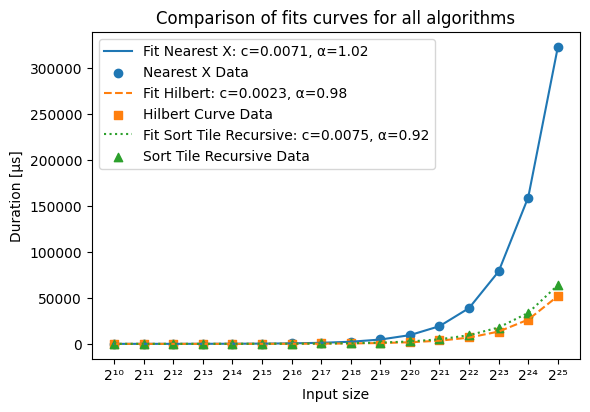

In [63]:
plt.figure(figsize=(6, 4))
x = range(16)
x_ticks = nearestx["n"]
plt.xticks(x, x_ticks)

y_nearest_fit = [time_function(n, *popt_nearestx) for n in [2**i for i in range(10, 26)]]
y_hilbert_fit = [time_function(n, *popt_hilbert) for n in [2**i for i in range(10, 26)]]
y_str_fit = [time_function(n, *popt_str) for n in [2**i for i in range(10, 26)]]

plt.plot(x, y_nearest_fit, label=f"Fit Nearest X: c={popt_nearestx[0]:.4f}, α={popt_nearestx[1]:.2f}", linestyle="-")
plt.scatter(x, y_nearestx, label="Nearest X Data", marker="o")

plt.plot(x, y_hilbert_fit, label=f"Fit Hilbert: c={popt_hilbert[0]:.4f}, α={popt_hilbert[1]:.2f}", linestyle="--")
plt.scatter(x, y_hilbert, label="Hilbert Curve Data", marker="s")

plt.plot(x, y_str_fit, label=f"Fit Sort Tile Recursive: c={popt_str[0]:.4f}, α={popt_str[1]:.2f}", linestyle=":")
plt.scatter(x, y_str, label="Sort Tile Recursive Data", marker="^")

plt.xlabel("Input size")
plt.ylabel("Duration [µs]")
plt.legend()
plt.tight_layout()
plt.title(f"Comparison of fits curves for all algorithms")